In [11]:
from qiskit import IBMQ, Aer, transpile, schedule as build_schedule
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes.calibration import RZXCalibrationBuilderNoEcho
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit_nature.algorithms import GroundStateEigensolver
from qiskit.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.utils import QuantumInstance
import matplotlib.pyplot as plt
import numpy as np

In [3]:
IBMQ.load_account()
provider = IBMQ.get_provider()
lagos = provider.get_backend('ibm_lagos')

In [12]:
def HEA_naive(num_q, depth):
    circuit = QuantumCircuit(num_q)
    params = ParameterVector("theta", length=num_q * (3 * depth + 2))
    counter = 0
    for q in range(num_q):
        circuit.rx(params[counter], q)
        counter += 1 
        circuit.rz(params[counter], q)
        counter += 1
    for d in range(depth):
        for q in range(num_q - 1):
            circuit.cx(q, q + 1)
        for q in range(num_q):
            circuit.rz(params[counter], q)
            counter += 1
            circuit.rx(params[counter], q)
            counter += 1 
            circuit.rz(params[counter], q)
            counter += 1
    return circuit, params

In [13]:
def HEA_aware(num_q, depth, hardware):
    circuit = QuantumCircuit(num_q)
    params = ParameterVector("theta", length=num_q * (3 * depth + 2))
    counter = 0
    for q in range(num_q):
        circuit.rx(params[counter], q)
        counter += 1 
        circuit.rz(params[counter], q)
        counter += 1
    for d in range(depth):
        for q in range(num_q - 1):
            gate = QuantumCircuit(num_q)
            gate.rzx(np.pi/2, q, q + 1)
            pass_ = RZXCalibrationBuilderNoEcho(hardware)
            qc_cr = PassManager(pass_).run(gate)
            circuit.compose(qc_cr, inplace=True)
        for q in range(num_q):
            circuit.rz(params[counter], q)
            counter += 1
            circuit.rx(params[counter], q)
            counter += 1 
            circuit.rz(params[counter], q)
            counter += 1
    return circuit, params

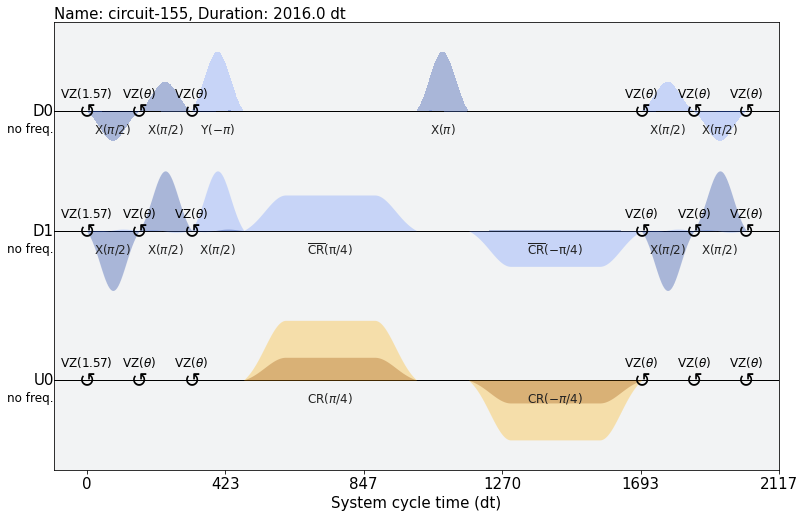

In [14]:
depth = 1
qubits = 2
back = lagos
circuit, _ = HEA_naive(qubits, depth)
t = transpile(circuit, back)
schedule = build_schedule(t, back)
schedule.draw()

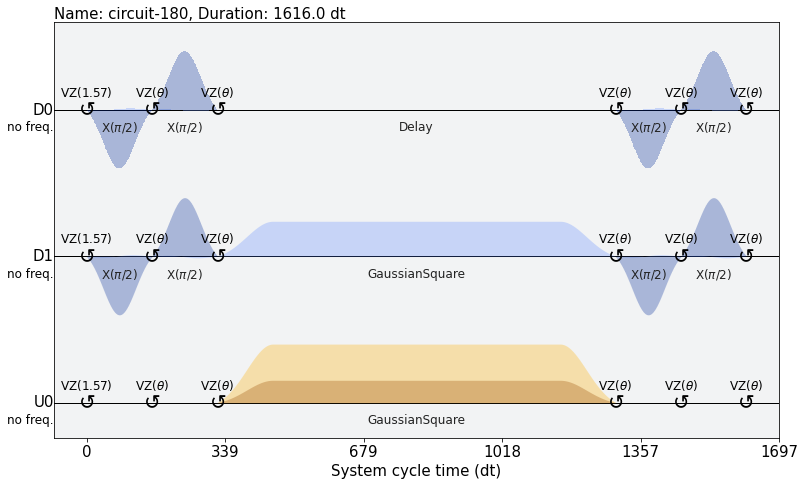

In [15]:
circuit, _ = HEA_aware(qubits, depth, back)
t = transpile(circuit, back)
schedule = build_schedule(t, back)
schedule.draw()

In [16]:
qubit_converter = QubitConverter(ParityMapper(), two_qubit_reduction=True)
numpy_solver = NumPyMinimumEigensolver()

In [17]:
spsa = SPSA(100)
qi = QuantumInstance(Aer.get_backend('aer_simulator'))
vqe_circuit = VQE(ansatz=circuit, quantum_instance=qi, optimizer=spsa)

In [22]:
# H2 simulation

total_dist = 4
dist = 0.1
incr_early = 0.1
incr_late = 0.3

real_energies = []
vqe_energies = []
dists = []
while dist < total_dist:
    print(dist, total_dist)
    molecule = Molecule(geometry=[['H', [0., 0., 0.]], ['H', [0., 0., dist]]])
    driver = ElectronicStructureMoleculeDriver(molecule, basis='sto3g', \
                                               driver_type=ElectronicStructureDriverType.PYSCF)

    es_problem = ElectronicStructureProblem(driver)
    second_q_ops = es_problem.second_q_ops()    
    
    if dist == 0.1:
        FermionicOp.set_truncation(0)
        print(second_q_ops[0])
        FermionicOp.set_truncation(1)
        print(qubit_converter.convert(second_q_ops[0], num_particles=es_problem.num_particles))
        print(es_problem.grouped_property)    

    calc = GroundStateEigensolver(qubit_converter, numpy_solver)
    res = calc.solve(es_problem)
    real_energies.append(np.real(res.total_energies[0]))

    calc = GroundStateEigensolver(qubit_converter, vqe_circuit)
    res = calc.solve(es_problem)
    vqe_energies.append(np.real(res.total_energies[0]))
    
    
    dists.append(dist)
    if dist > total_dist / 2:
        dist += incr_late
    else:
        dist += incr_early

0.1 4
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -2.581811338333
  - computed part:      -2.581811338333
~ Nuclear repulsion energy (Hartree): 5.2917721092
> Total ground state energy (Hartree): 2.709960770867
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  0.18897261]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  0.18897261]
    - computed part:      [0.0  0.0  0.18897261]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  -0.00000001]  Total: 0.00000001
 
[2.70996077]
{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 200,
    'eigenstate': {'01': 1.0},
    'eigenvalue': (-2.584682609490058+0j),
    'optimal_parameters': {   ParameterVectorElement(theta[5]): 3.2122708428818707,
                              ParameterVectorElement(theta[8]): -7.231120436275923,
                       

KeyboardInterrupt: Interrupted by user

ValueError: x and y must have same first dimension, but have shapes (0,) and (1,)

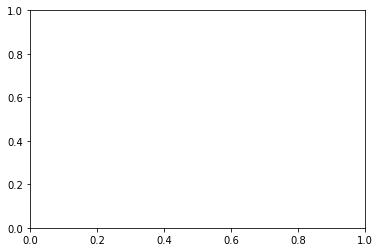

In [21]:
plt.plot(dists, real_energies, label='Real', color='red')
plt.scatter(dists, vqe_energies, label='VQE', color='black')
plt.title("H2")
plt.ylim(-1.2, 0.4)
plt.xlim(0, 4)
plt.xlabel('Angstroms')
plt.ylabel('Hartree')
plt.legend()
plt.show()

In [11]:
depth = 2
qubits = 4
circuit, _ = HEA_naive(qubits, depth)
spsa = SPSA(100)
qi = QuantumInstance(Aer.get_backend('aer_simulator'))
vqe_circuit = VQE(ansatz=circuit, quantum_instance=qi, optimizer=spsa)
#print(circuit)

In [12]:
total_dist = 5
dist = 0.3
incr_early = 0.1
incr_late = 0.3

real_energies = []
vqe_energies = []
dists = []
while dist < total_dist:
    print(dist, total_dist)
    molecule = Molecule(geometry=[['Li', [0., 0., 0.]], ['H', [0., 0., dist]]])
    driver = ElectronicStructureMoleculeDriver(molecule, basis='sto3g', \
                                               driver_type=ElectronicStructureDriverType.PYSCF)
    
    transformer = FreezeCoreTransformer(freeze_core=True, remove_orbitals=[3, 4])
    es_problem = ElectronicStructureProblem(driver, transformers=[transformer])
    second_q_ops = es_problem.second_q_ops()    

    if dist == 0.3:
        print(second_q_ops[0])
        print(qubit_converter.convert(second_q_ops[0], num_particles=es_problem.num_particles))
        print(es_problem.grouped_property)    
        print(es_problem.grouped_property_transformed)

    calc = GroundStateEigensolver(qubit_converter, numpy_solver)
    res = calc.solve(es_problem)
    real_energies.append(np.real(res.total_energies[0]))

    calc = GroundStateEigensolver(qubit_converter, vqe_circuit) #VQEClient()
    res = calc.solve(es_problem)
    vqe_energies.append(np.real(res.total_energies[0]))
    
    dists.append(dist)
    if dist > total_dist / 2:
        dist += incr_late
    else:
        dist += incr_early

0.3 5
Fermionic Operator
register length=6, number terms=117
  (0.047491900810976574+0j) * ( +_0 -_1 +_3 -_4 )
+ (0.009910304858181255+0j) * ( +_0 -_1 +_3 -_5 )
+ (-0.04749190081097658+0j) * ( +_0 -_1 -_3 +_4 )
+ (-0.009910304858181309+0j) * ( +_0 -_1 -_3 +_5 )
+ (0.02109034903198569+0j) * ( +_0 -_1 +_4 -_5 )
+ (-0.021090349031985676+0j) * ( +_0 -_1 -_4 +_5 )
+ (-0.039975346997359704+0j) * ( +_0 -_1 )
+ (0.06013958508804303+0j) * ( +_0 -_1 +_5 -_5 )
+ (-0.011745821714011857+0j) * ( +_0 -_1 +_4 -_4 )
+ (0.03997536383834381+0j) * ( +_0 -_1 +_3 -_3 )
+ (0.02665748633947592+0j) * ( +_0 -_1 +_2 -_2 )
+ (0.009910304858181255+0j) * ( +_0 -_2 +_3 -_4 )
+ (0.06665219868195824+0j) * ( +_0 -_2 +_3 -_5 )
+ (-0.009910304858181292+0j) * ( +_0 -_2 -_3 +_4 )
+ (-0.06665219868195844+0j) * ( +_0 -_2 -_3 +_5 )
+ (0.033482098748567155+0j) * ( +_0 -_2 +_4 -_5 )
+ (-0.033482098748567106+0j) * ( +_0 -_2 -_4 +_5 )
+ (-0.0606292881997606+0j) * ( +_0 -_2 )
+ (0.15015182933433197+0j) * ( +_0 -_2 +_5 -_5 )
+ (0.0

0.4 5
0.5 5
0.6 5
0.7 5
0.7999999999999999 5
0.8999999999999999 5
0.9999999999999999 5
1.0999999999999999 5
1.2 5
1.3 5
1.4000000000000001 5
1.5000000000000002 5
1.6000000000000003 5
1.7000000000000004 5
1.8000000000000005 5
1.9000000000000006 5
2.0000000000000004 5
2.1000000000000005 5
2.2000000000000006 5
2.3000000000000007 5
2.400000000000001 5
2.500000000000001 5
2.8000000000000007 5
3.1000000000000005 5
3.4000000000000004 5
3.7 5
4.0 5
4.3 5
4.6 5
4.8999999999999995 5


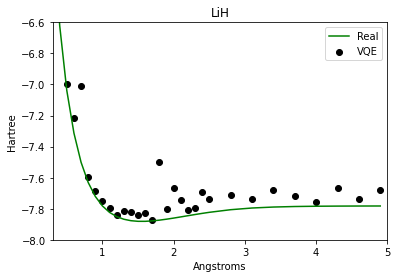

In [13]:
plt.plot(dists, real_energies, label='Real', color='green')
plt.scatter(dists, vqe_energies, label='VQE', color='black')
plt.title("LiH")
plt.ylim(-8, -6.6)
plt.xlim(0.3, 5)
plt.xlabel('Angstroms')
plt.ylabel('Hartree')
plt.legend()
plt.show()

In [14]:
depth = 2
qubits = 6
circuit, _ = HEA_naive(qubits, depth)
spsa = SPSA(100)
qi = QuantumInstance(Aer.get_backend('aer_simulator'))
vqe_circuit = VQE(ansatz=circuit, quantum_instance=qi, optimizer=spsa)
#print(circuit)

In [15]:
total_dist = 5
dist = 0.4
incr_early = 0.2
incr_late = 0.4

real_energies = []
vqe_energies = []
dists = []
while dist < total_dist:
    print(dist, total_dist)
    molecule = Molecule(geometry=[['H', [0., 0., -dist]], ['Be', [0., 0., 0.]], ['H', [0., 0., dist]]])
    driver = ElectronicStructureMoleculeDriver(molecule, basis='sto3g', \
                                               driver_type=ElectronicStructureDriverType.PYSCF)

    transformer = FreezeCoreTransformer(freeze_core=True, remove_orbitals=[4, 5])
    es_problem = ElectronicStructureProblem(driver, transformers=[transformer])
    second_q_ops = es_problem.second_q_ops()    

    if dist == 0.4:
        print(second_q_ops[0])
        print(qubit_converter.convert(second_q_ops[0], num_particles=es_problem.num_particles))
        print(es_problem.grouped_property)    
        print(es_problem.grouped_property_transformed)

    calc = GroundStateEigensolver(qubit_converter, numpy_solver)
    res = calc.solve(es_problem)
    real_energies.append(np.real(res.total_energies[0]))

    calc = GroundStateEigensolver(qubit_converter, vqe_circuit)
    res = calc.solve(es_problem)
    vqe_energies.append(np.real(res.total_energies[0]))
    
    dists.append(dist)
    if dist > total_dist / 2:
        dist += incr_late
    else:
        dist += incr_early

0.4 5
Fermionic Operator
register length=8, number terms=104
  (0.102557140774307+0j) * ( +_0 -_1 +_4 -_5 )
+ (-0.09292580229567163+0j) * ( +_0 -_1 +_4 -_7 )
+ (-0.10255714077430707+0j) * ( +_0 -_1 -_4 +_5 )
+ (0.092925802295672+0j) * ( +_0 -_1 -_4 +_7 )
+ (0.0213334565041448+0j) * ( +_0 -_2 +_4 -_6 )
+ (-0.02133345650414479+0j) * ( +_0 -_2 -_4 +_6 )
+ (-0.09292580229567163+0j) * ( +_0 -_3 +_4 -_5 )
+ (0.12507958237707117+0j) * ( +_0 -_3 +_4 -_7 )
+ (0.09292580229567157+0j) * ( +_0 -_3 -_4 +_5 )
+ (-0.12507958237706984+0j) * ( +_0 -_3 -_4 +_7 )
+ (-0.10255714077430707+0j) * ( -_0 +_1 +_4 -_5 )
+ (0.09292580229567157+0j) * ( -_0 +_1 +_4 -_7 )
+ (0.10255714077430704+0j) * ( -_0 +_1 -_4 +_5 )
+ (-0.09292580229567213+0j) * ( -_0 +_1 -_4 +_7 )
+ (-0.02133345650414479+0j) * ( -_0 +_2 +_4 -_6 )
+ (0.02133345650414478+0j) * ( -_0 +_2 -_4 +_6 )
+ (0.092925802295672+0j) * ( -_0 +_3 +_4 -_5 )
+ (-0.12507958237706984+0j) * ( -_0 +_3 +_4 -_7 )
+ (-0.09292580229567213+0j) * ( -_0 +_3 -_4 +_5 )
+ (0.

0.6000000000000001 5
0.8 5
1.0 5
1.2 5
1.4 5
1.5999999999999999 5
1.7999999999999998 5
1.9999999999999998 5
2.1999999999999997 5
2.4 5
2.6 5
3.0 5
3.4 5
3.8 5
4.2 5
4.6000000000000005 5


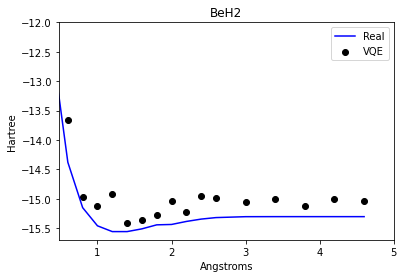

In [19]:
plt.plot(dists, real_energies, label='Real', color='blue')
plt.scatter(dists, vqe_energies, label='VQE', color='black')
plt.title("BeH2")
plt.ylim(-15.7, -12.0)
plt.xlim(0.48, 5)
plt.xlabel('Angstroms')
plt.ylabel('Hartree')
plt.legend()
plt.show()

In [1]:
from qiskit.tools.jupyter import *

%qiskit_version_table